Library import

In [2]:
import pandas as pd
import numpy as np
from cpi import inflate
import matplotlib.pyplot as plt

Files loading

#### A. Sequels

In [4]:
#Load movie databases
movie_df = pd.read_csv('data/MovieSummaries/movie.metadata.tsv', sep='\t', header=None)

#rename columns
movie_df.rename(columns={0: 'Wikipedia movie ID', 1: "Freebase movie ID", 2: "Movie name",  3: "Movie release date", 4: "Movie box office revenue", 5: "Movie runtime", 6: "Movie languages", 7: "Movie countries", 8: "Movie genres"}, inplace=True)

sequel_collections_with_wiki_id = pd.read_csv('data/collections/sequels_and_original_with_wiki_id.csv')
sequels_with_wiki_id = pd.read_csv('data/movie_with_keyword_sequel_with_wiki_id.csv')

sequels_metadata_recent_df = pd.read_csv('data/sequels/sequels_metadata_2010_2024.csv')

In [26]:
# Loading books, comics and remakes
books_with_wiki_id = pd.read_csv('data/book/book_with_wiki_id_1880_2010.csv')
books_metadata_recent_df = pd.read_csv('data/book/book_metadata_2010_2024.csv')

comics_with_wiki_id = pd.read_csv('data/comics/comics_with_wiki_id_1880_2010.csv')
comics_metadata_recent_df = pd.read_csv('data/comics/comics_metadata_2010_2024.csv')

remakes_with_wiki_id = pd.read_csv('data/remake/remake_with_wiki_id_1880_2010.csv')
remakes_metadata_recent_df = pd.read_csv('data/remake/remake_metadata_2010_2024.csv')

movie_recent_df = pd.read_csv('data/random_sample/random_sample_2010_2024.csv')

Inner join between "movie_df" and sequels with their Wikipedia ID

In [13]:
#sequels
movie_df_sequel_original = movie_df.join(sequel_collections_with_wiki_id.set_index('Wikipedia movie ID'), on="Wikipedia movie ID", how='inner')
movie_df_sequel_only = movie_df.join(sequels_with_wiki_id.set_index('Wikipedia movie ID'), on="Wikipedia movie ID", how='inner')

#books
movie_df_books = movie_df.join(books_with_wiki_id.set_index('Wikipedia movie ID'), on="Wikipedia movie ID", how='inner')

#comics
movie_df_comics = movie_df.join(comics_with_wiki_id.set_index('Wikipedia movie ID'), on="Wikipedia movie ID", how='inner')

#remakes
movie_df_remakes = movie_df.join(remakes_with_wiki_id.set_index('Wikipedia movie ID'), on="Wikipedia movie ID", how='inner')

In [14]:
TMDB_sizes = [sequel_collections_with_wiki_id.shape[0], sequels_with_wiki_id.shape[0], books_with_wiki_id.shape[0], comics_with_wiki_id.shape[0], remakes_with_wiki_id.shape[0]]

Wikipedia_sizes = [movie_df_sequel_original.shape[0], movie_df_sequel_only.shape[0], movie_df_books.shape[0], movie_df_comics.shape[0], movie_df_remakes.shape[0]]

Filtering movies by consistent release year

In [15]:
def drop_different_years(df):
    """
    Drop rows with different release years between the Wikipedia and TMDb datasets
    """
    df["release year wiki"] = df["Movie release date"].apply(lambda x: str(x)[:4] if str.isdigit(str(x)[:4]) else np.nan)
    df["release year tmdb"] = df["release_date"].apply(lambda x: str(x)[:4] if str.isdigit(str(x)[:4]) else np.nan)
    
    df.drop(df[df["release year wiki"] != df["release year tmdb"]].index, inplace=True)
    df["release year"] = df["release year wiki"].astype(float)
    df.drop("release year tmdb", axis=1, inplace=True)
    df.drop("release year wiki", axis=1, inplace=True)

    return df

In [16]:
movie_df_sequel_original = drop_different_years(movie_df_sequel_original)
movie_df_sequel_only = drop_different_years(movie_df_sequel_only)
movie_df_books = drop_different_years(movie_df_books)
movie_df_comics = drop_different_years(movie_df_comics)
movie_df_remakes = drop_different_years(movie_df_remakes)

In [17]:
#Sizes after filtering
movie_errors_sizes = [movie_df_sequel_original.shape[0], movie_df_sequel_only.shape[0], movie_df_books.shape[0], movie_df_comics.shape[0], movie_df_remakes.shape[0]]

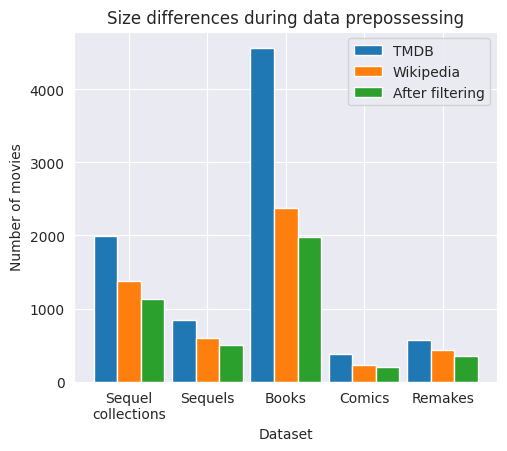

In [18]:
## Size differences
width = 0.3

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(221)

ind = np.arange(5)

ax.bar(ind, TMDB_sizes, width = width, label="TMDB")
ax.bar(ind + width, Wikipedia_sizes, width = width, label="Wikipedia")
ax.bar(ind + 2 * width, movie_errors_sizes, width = width, label="After filtering")

plt.xticks(ind + width, ["Sequel\ncollections", "Sequels", "Books", "Comics", "Remakes"])

ax.legend()
ax.title.set_text("Size differences during data prepossessing")
ax.set_xlabel("Dataset")
ax.set_ylabel("Number of movies")

plt.show()

### 3.1 How many sequels are there compared to movies 

Groups the movies by 5-year intervals, counts how many movies fall into each interval, and returns the string representation of the interval labels

Plot of number of movies per 5 year (left figure) VS. Plot of number of movies with sequels per 5 year (right figure)

In [29]:
def add_release_year(df : pd.DataFrame, column_name : str) -> pd.DataFrame:
    """
    Add a column with the release year to the dataframe
    """
    df["release year"] = df[column_name].apply(lambda x: str(x)[:4] if str.isdigit(str(x)[:4]) else np.nan)
    df["release year"] = df["release year"].astype(float)
    return df

In [30]:
def movies_per_year(df : pd.DataFrame,  start_year : int, end_year : int, interval : int = 5) -> tuple:
    """
    Groups the movies by 5-year intervals, counts how many movies fall into each interval, and returns the string representation of the interval labels
    """
    movies_per_years_df = df.groupby(pd.cut(df["release year"], np.arange(start_year, end_year, interval))).count()
    years = movies_per_years_df.index.astype(str)
    years = [x[1:][:-1] for x in years]
    return movies_per_years_df, years

In [35]:
movie_df = add_release_year(movie_df, "Movie release date")
movie_df_sequel_original = add_release_year(movie_df_sequel_original, "release_date")
movie_recent_df = add_release_year(movie_recent_df, "release_date")
sequels_metadata_recent_df = add_release_year(sequels_metadata_recent_df, "Movie release date")
books_metadata_recent_df = add_release_year(books_metadata_recent_df, "Movie release date")
comics_metadata_recent_df = add_release_year(comics_metadata_recent_df, "Movie release date")
remakes_metadata_recent_df = add_release_year(remakes_metadata_recent_df, "Movie release date")

In [36]:
#grouping and count movies by release year 1890-2010
movies_per_years, movies_years = movies_per_year(movie_df, 1890, 2010)
sequel_per_year, sequel_years = movies_per_year(movie_df_sequel_only, 1890, 2010)
book_per_year, book_years = movies_per_year(movie_df_books, 1890, 2010)
comics_per_year, comics_years = movies_per_year(movie_df_comics, 1890, 2010)
remakes_per_year, remakes_years = movies_per_year(movie_df_remakes, 1890, 2010)

#grouping and count movies by release year 2010-2024
movies_per_years_recent, movies_years_recent = movies_per_year(movie_recent_df, 2010, 2024)
sequel_per_year_recent, sequel_years_recent = movies_per_year(sequels_metadata_recent_df, 2010, 2024)
book_per_year_recent, book_years_recent = movies_per_year(books_metadata_recent_df, 2010, 2024)
comics_per_year_recent, comics_years_recent = movies_per_year(comics_metadata_recent_df, 2010, 2024)
remakes_per_year_recent, remakes_years_recent = movies_per_year(remakes_metadata_recent_df, 2010, 2024)


In [44]:
def figure_movie_year(df, movie_type, years, ax_f, split = 5):
    """
    Plot of number of movies per 5 year
    """  
    ax_f.bar(years, df["Movie name"], label=f"Number of {movie_type}")
    ax_f.legend()
    ax_f.title.set_text(f"Number of {movie_type} per {split} years splits")
    ax_f.set_xlabel("Year")
    ax_f.set_ylabel("Number of movies")
    start_year = [int(x[:4]) for x in years]
    ax_f.set_xticks(years, labels=start_year, rotation = 90)
    return ax_f

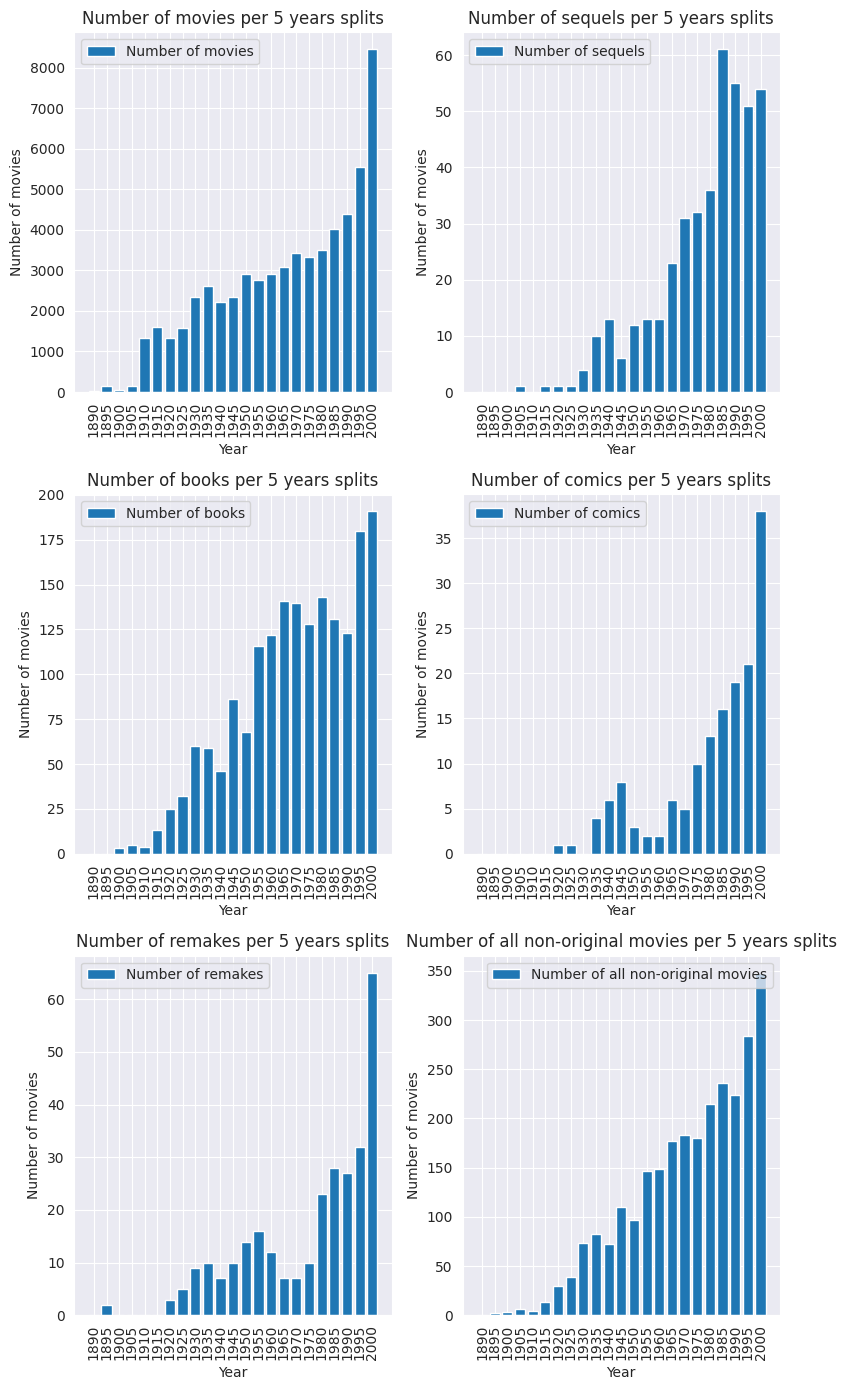

In [46]:
#Plot figure 1 (left):  number of movies per 5 years

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(8,14))
ax1 = figure_movie_year(movies_per_years, "movies", movies_years, ax1)
ax2 = figure_movie_year(sequel_per_year, "sequels", sequel_years, ax2)
ax3 = figure_movie_year(book_per_year, "books", book_years, ax3)
ax4 = figure_movie_year(comics_per_year, "comics", comics_years, ax4)
ax5 = figure_movie_year(remakes_per_year, "remakes", remakes_years, ax5)
ax6 = figure_movie_year(sequel_per_year + book_per_year + comics_per_year + remakes_per_year, "all non-original movies", sequel_years, ax6)
plt.tight_layout()
plt.show()

KeyError: 'Movie name'

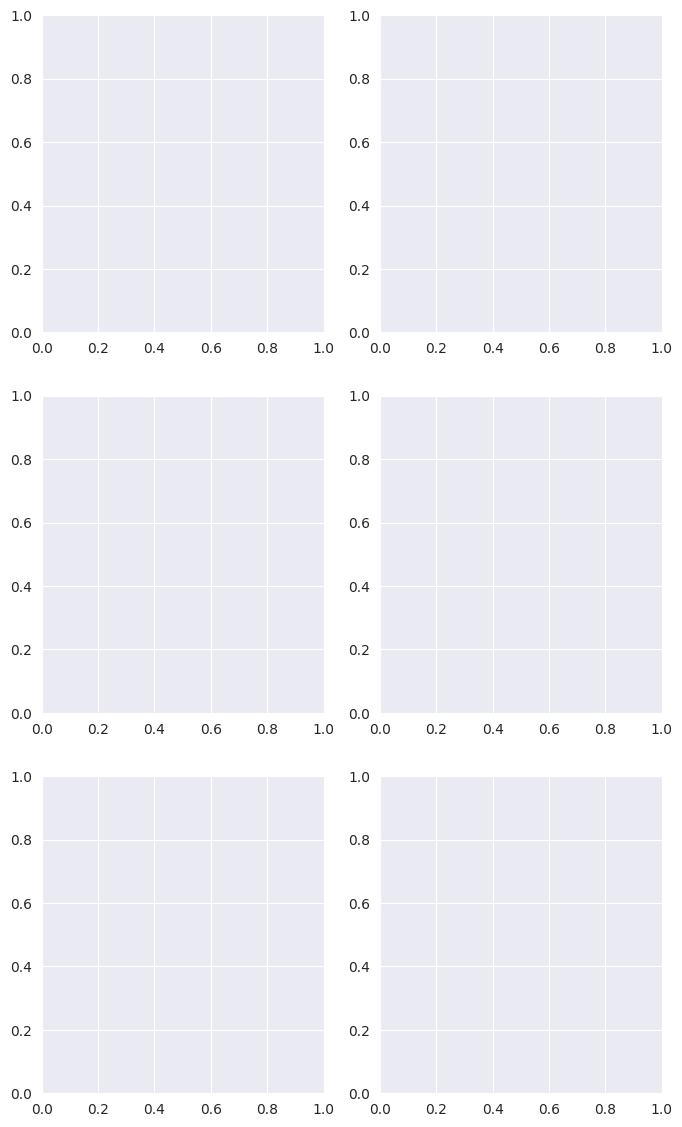

In [47]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(8,14))
ax1 = figure_movie_year(movies_per_years_recent, "movies", movies_years_recent, ax1, 4)
ax2 = figure_movie_year(sequel_per_year_recent, "sequels", sequel_years_recent, ax2, 4)
ax3 = figure_movie_year(book_per_year_recent, "books", book_years_recent, ax3, 4)
ax4 = figure_movie_year(comics_per_year_recent, "comics", comics_years_recent, ax4, 4)
ax5 = figure_movie_year(remakes_per_year_recent, "remakes", remakes_years_recent, ax5, 4)
ax6 = figure_movie_year(sequel_per_year_recent + book_per_year_recent + comics_per_year_recent + remakes_per_year_recent, "all non-original movies", sequel_years_recent, ax6, 4)
plt.tight_layout()
plt.show()

$$
\text{Ratio} = \frac{\text{nb of movie with sequel per 5 year}}{\text{nb of movie per 5 year}}
$$

In [ ]:
def plot_ratio(df, movies_per_years, ax_f, split = 5):
    """
    Plot of the ratio of movies with sequels per 5 year
    """
    ratio = df["Wikipedia movie ID"] / movies_per_years["Wikipedia movie ID"] * 100
    ratio = ratio.fillna(0)
    plt.plot(sequel_years, ratio)
    plt.title("Ratio of movies with sequels per 5 year")
    plt.xlabel("Year")
    plt.ylabel("Ratio")
    plt.xticks(rotation=45, ha='right')
    plt.show()
    

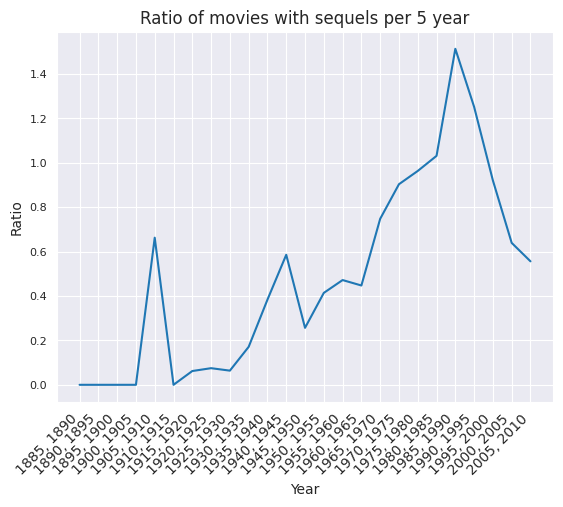

In [65]:
movie_df_ratio = sequel_per_year / movies_per_years_removed * 100
movie_df_ratio = movie_df_ratio.fillna(0)

plt.plot(sequel_years, movie_df_ratio["Wikipedia movie ID"])
plt.title("Ratio of movies with sequels per 5 year")
plt.xlabel("Year")
plt.ylabel("Ratio")
plt.xticks(rotation=45, ha='right')
plt.show()

## 3.2 Box office revenue

#### 3.2.1 Box office revenue for movies with sequels compared to all movies

Creation of a function, using the Consumer Price Index (CPI), that calaculate the inflation adjustement for each movies based on their released year

In [1]:

def inflate(revenue, year):
    if np.isnan(revenue) or np.isnan(year) or year < 1900:  #no inflation adjustement for missing values or years before 1900
        return np.nan
    if len(str(year)) != 4:
        year = int(str(year)[:4])
    return cpi.inflate(revenue, year)                       #apply Consumer Price Index (cpi) inflation adjustement

# applying the function to all movies and create a new column with the adjusted revenue

movie_df["Movie box office revenue inflation adj"] = movie_df.apply(lambda x: inflate(x["Movie box office revenue"], x["release year"]), axis=1)

NameError: name 'movie_df' is not defined

Box office revenues inflation adjustement for other movies with sequels dataframe

In [ ]:
movie_df_sequel_only["Movie box office revenue inflation adj"] = movie_df_sequel_only.apply(lambda x: inflate(x["Movie box office revenue"], x["release year"]), axis=1)
movie_df_sequel_original["Movie box office revenue inflation adj"] = movie_df_sequel_original.apply(lambda x: inflate(x["Movie box office revenue"], x["release year"]), axis=1)

Calculation and plot of total box office revenue per year

In [ ]:
#sum of the box office revenue per year, first for all movies, then for movies with sequels

box_office_per_year = movie_df.groupby("release year")["Movie box office revenue inflation adj"].agg('sum')
box_office_sequel_per_year = movie_df_sequel_only.groupby("release year")["Movie box office revenue inflation adj"].agg('sum')

#replace NaN values by 0

box_office_per_year = box_office_per_year.fillna(0)
box_office_sequel_per_year = box_office_sequel_per_year.fillna(0)

"""
fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot()
ax1.plot(box_office_per_year.index, box_office_per_year, label="Box office revenue")
ax1.legend()
ax1.title.set_text("Box office revenue per year")
ax1.set_xlabel("Year")
ax1.set_ylabel("Box office revenue")

ax2 = fig.add_subplot()
ax2.plot(box_office_sequel_per_year.index, box_office_sequel_per_year, label="Box office revenue sequel")
ax2.legend()
ax2.title.set_text("Box office revenue sequel per year")
ax2.set_xlabel("Year")
ax2.set_ylabel("Box office revenue")
"""

# Plot figure 4: box office revenue per year

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(box_office_per_year.index, box_office_per_year, label="Box office revenue")
ax.plot(box_office_sequel_per_year.index, box_office_sequel_per_year, label="Box office revenue sequel")

plt.draw()                                                  # Draw the plot to get the current y-axis offset
y_axis_offset = ax.get_yaxis().get_offset_text().get_text() # get the scientific notation multiplier from the axis and use it in the label
ax.set_ylabel(f"Box office revenue [{y_axis_offset}$]")
ax.get_yaxis().get_offset_text().set_visible(False)         # remove the scientific notation from the axis to avoid duplication
ax.legend()
ax.set_title("Box office revenue per year")
ax.set_xlabel("Year")

plt.show()

Calculation and plots the percentage of box office revenue each year contributed by movies with sequels, relative to the total box office revenue for all movies that year

$$
\text{Box Office \%} = \frac{\text{Box office of movies with sequel per year}}{\text{Box office for all movies per year}} * 100
$$

In [ ]:
# calculate the percentage of box office revenue from movies with sequels

box_office_percentage = box_office_sequel_per_year / box_office_per_year * 100

# Plot figure 5: box office revenue percentage per year

box_office_percentage_plot, ax = plt.subplots()
ax.bar(box_office_percentage.index, box_office_percentage, label="Box office revenue percentage", width=1)
ax.legend(loc='upper left')
ax.title.set_text("Box office revenue percentage from 1970")
ax.set_xlabel("Year")
ax.set_ylabel("Percentage (%)")
plt.show()

Calculation and plot of the average inflation-adjusted box office revenue per year, both for all movies and for movies with sequels

In [ ]:
#calculate box office revenue per movie and fill NaN values with 0

average_box_office = movie_df.dropna(subset = ['Movie box office revenue inflation adj']).groupby("release year")["Movie box office revenue inflation adj"].agg('mean')
average_box_office = average_box_office.fillna(0)

#calculate box office revenue per movie for movies with sequels and fill NaN values with 0

average_box_office_sequel = movie_df_sequel_only.dropna(subset = ['Movie box office revenue inflation adj']).groupby("release year")["Movie box office revenue inflation adj"].agg('mean')
average_box_office_sequel = average_box_office_sequel.fillna(0)

# Plot figure 6: average box office revenue per year

average_box_office_plot, ax = plt.subplots()
ax.plot(average_box_office.index, average_box_office, label="Average box office revenue")
ax.plot(average_box_office_sequel.index, average_box_office_sequel, label="Average box office revenue sequel")

plt.draw()                                                  # Draw the plot to get the current y-axis offset
y_axis_offset = ax.get_yaxis().get_offset_text().get_text() # get the scientific notation multiplier from the axis and use it in the label
ax.set_ylabel(f"Revenue [{y_axis_offset}$]")
ax.get_yaxis().get_offset_text().set_visible(False)         # remove the scientific notation from the axis to avoid duplication
ax.legend()
ax.set_title("Average Box Office Revenue per Year")
plt.show()

#### 3.2.2 Box office revenue for movies with sequel compared to the first movie of the collection

In [ ]:
#identify and calculate the box office revenue of the first movie in each collection

box_office_first_movie = movie_df_sequel_original.sort_values("release_date").groupby("collection").first()["Movie box office revenue inflation adj"]

#calculate the remaining box office revenue for each collection

box_office_remainder = movie_df_sequel_original.groupby("collection")["Movie box office revenue inflation adj"].agg('sum') - box_office_first_movie

#calculate the remaining box office revenue for each collection (excluding the first movie)

box_office_remainder_avg = box_office_remainder / (movie_df_sequel_original.groupby("collection").count()["Movie name"] - 1)

Creation of new DataFrame in order to store first movie and remain movies box office value

In [ ]:
first_vs_rest = pd.DataFrame()
first_vs_rest["first"] = box_office_first_movie
first_vs_rest["rest"] = box_office_remainder
first_vs_rest["rest_avg"] = box_office_remainder_avg

first_vs_rest = first_vs_rest[first_vs_rest["rest"] > 0]                #remove collections with no revenue
first_vs_rest = first_vs_rest.sort_values("first", ascending=True)      #sort in ascending order for the first movie (lowest to the highest)

In [ ]:
first_vs_rest['index'] = range(0, len(first_vs_rest))

Plot the comparison between first and remaining movie of collections

In [ ]:
fig = plt.figure(figsize=(12, 10))

#calculate the average adjusted box office revenue for all movies

average_movie_revenue = movie_df.dropna(subset = ['Movie box office revenue inflation adj'])["Movie box office revenue inflation adj"].agg('mean')

#Plot figure 7: first movie vs sequel movie box office revenue

ax1 = fig.add_subplot(221)
x = first_vs_rest["index"]
y1 = first_vs_rest["first"]
y2 = first_vs_rest["rest"]
ax1.plot(x, y1, 'ks', markersize = 4, label="First movie box office revenue")
ax1.plot(x, y2, 'bo', markersize = 4, label="Sequel movie box office revenue")

ax1.plot((x[y1>y2],x[y1>y2]),(y1[y1>y2], y2[y1 > y2]),c= "red", alpha=0.5)      #the first movie has a lower revenue than the sequel
ax1.plot((x[y1<y2],x[y1<y2]),(y1[y1<y2], y2[y1 < y2]),c= "green", alpha=0.5)    #the first movie has a higher revenue than the sequel

ax1.legend()
ax1.title.set_text("First movie vs Sequel movie box office revenue")
ax1.set_xlabel("Collection")
ax1.set_ylabel("Box office revenue")
ax1.set_yscale("log")

#Plot figure 8: first movie vs average sequel movie box office revenue

ax2 = fig.add_subplot(222)
x = first_vs_rest["index"]
y1 = first_vs_rest["first"]
y2 = first_vs_rest["rest_avg"]
ax2.plot(x, y1, 'ks', markersize = 4, label="First movie box office revenue")
ax2.plot(x, y2, 'bo', markersize = 4, label="Sequel movie box office revenue average")

ax2.plot((x[y1>y2],x[y1>y2]),(y1[y1>y2], y2[y1 > y2]),c= "red", alpha=0.5)                                  #the first movie has a lower revenue than the average sequel
ax2.plot((x[y1<y2],x[y1<y2]),(y1[y1<y2], y2[y1 < y2]),c= "green", alpha=0.5)                                #the first movie has a higher revenue than the average sequel
ax2.axhline(y=average_movie_revenue, color='y', linestyle='-', label="Average movie box office revenue")    #average revenue for all movies

ax2.legend()
ax2.title.set_text("First movie box vs average Sequel movie box office revenue")
ax2.set_xlabel("Collection")
ax2.set_ylabel("Box office revenue")
ax2.set_yscale("log")

plt.show()


These plots highlight where the first movie outperforms the sequel (red lines) and vice versa (green lines). The second plot also includes a yellow horizontal line showing the average box office revenue of all movies in the dataset.

The log scale on the y-axis is used to better visualize large differences in revenue, especially when there are very high values.

## 4. Number of movies in a collection

In [ ]:
movie_df_sequel_original

In [ ]:
#total number of movies in each collection

collection_size = movie_df_sequel_original.groupby("collection").count()["Movie name"]

#total inflation adjusted box office revenue for each collection

box_office_revenue = movie_df_sequel_original.groupby("collection")["Movie box office revenue inflation adj"].agg('sum')

sequels_extended = pd.read_csv("data/sequels/sequels_extended_1880_2010.csv") #dataframe with additional budget information
#movie_df_sequel_original = pd.merge(movie_df_sequel_original, sequels_extended[["id", "budget"]], on="id", how="inner") 

#total budget for each collection

budget_df = movie_df_sequel_original.groupby("collection")["budget"].agg('sum')

In [ ]:
len(collection_size) #nb of unique collection with sequels

Plot of the comparison between the Budget and the Box office revenue for collection

In [ ]:
import seaborn as sns

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(221)

ax.scatter(budget_df, box_office_revenue, s = collection_size * 50, alpha=0.5, c = box_office_revenue, cmap="cool")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Budget")
ax.set_ylabel("Box office revenue")

ax.set_xlim(xmin = 1e5)
ax.set_ylim(ymax = 5e11)

ax.title.set_text("Budget vs Box office revenue")
plt.show()

In [ ]:
#Plot figure 10: number of movies in a collection

fig = plt.figure(figsize=(12, 10))

ax1 = fig.add_subplot()
ax1.bar(collection_size['Movie name'], collection_size["count"], label="Number of movies in collection")
ax1.legend()
ax1.title.set_text("Number of movies in a collection")
ax1.set_xlabel("Number of sequels")
ax1.set_ylabel("Number of movies")

plt.show()

## Other line of enquiry:

- Highest grossing series
- By genre
- Find studios that do a lot of sequels
- Is there a correlation between the box office revenue of the first movie and the sequels
- Add more box office revenue data and get movie budget data
- ...